In [1]:
# https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/
# https://colab.research.google.com/drive/1_J2MrBSvsJfOcVmYAN2-WSp36BtsFZCa#scrollTo=ZnN1K63BYomX

In [2]:
import numpy as np

import torch

import copy
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
# from arff2pandas import a2p

from scipy.io import arff
import pandas as pd

In [3]:
# %matplotlib inline
# %config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
tr0 = arff.loadarff('./ECG5000/ECG5000_TRAIN.arff')
te0 = arff.loadarff('./ECG5000/ECG5000_TEST.arff')

In [6]:
# Anomalous data
N = 100  # number of samples
L = 128  # length of each sample (number of values for each sine wave)
T = 20   # width of the wave
x = np.empty((N,L), np.float32) # instantiate empty array
x[:] = np.arange(L) + np.random.randint(-4*T, 4*T, N).reshape(N,1)

freq = 2.
te0 = np.sin(freq*x/1.0/T).astype(np.float32) # + np.random.normal(0,0.025,np.size(x)).reshape(N,L)


# Normal data
N = 900  # number of samples
L = 128  # length of each sample (number of values for each sine wave)
T = 20   # width of the wave
x = np.empty((N,L), np.float32) # instantiate empty array
x[:] = np.arange(L) + np.random.randint(-4*T, 4*T, N).reshape(N,1)
tr0 = np.sin(x/1.0/T).astype(np.float32)


# plt.plot(y[0],marker='*')
# plt.show()

In [7]:
train = pd.DataFrame(tr0)
train = train.assign(label=np.ones(len(tr0)))

test = pd.DataFrame(te0)
test = test.assign(label=2*np.ones(len(te0)))

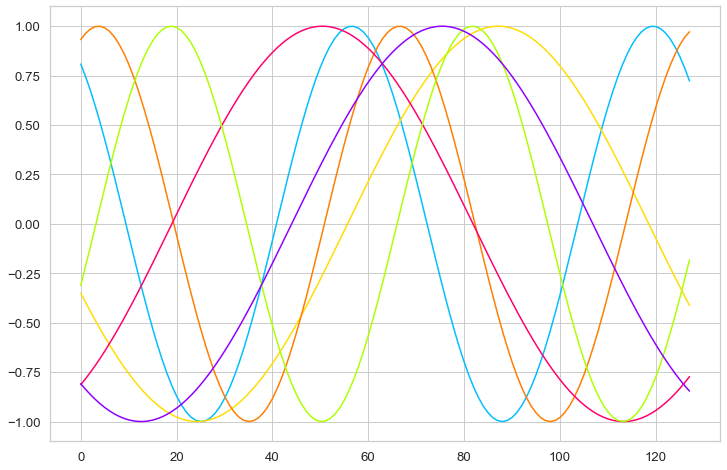

In [8]:
for i in range(3):
    plt.plot(te0[i])
    plt.plot(tr0[i])
plt.show()

In [9]:
df = pd.concat([train,test])
df = df.sample(frac=1.0)
print(df.shape)
print(df.head())

(1000, 129)
            0         1         2         3         4         5         6  \
368 -0.611858 -0.650625 -0.687766 -0.723188 -0.756802 -0.788525 -0.818277   
559  0.522687  0.564642  0.605186  0.644218  0.681639  0.717356  0.751280   
670  0.206902  0.157746  0.108195  0.058374  0.008407 -0.041581 -0.091465   
66   0.637765  0.598472  0.557684  0.515501  0.472030  0.427380  0.381661   
103 -0.206902 -0.255541 -0.303542 -0.350783 -0.397148 -0.442520 -0.486787   

            7         8         9  ...       119       120       121  \
368 -0.845984 -0.871576 -0.894989  ... -0.319519 -0.366479 -0.412523   
559  0.783327  0.813416  0.841471  ...  0.215120  0.263660  0.311541   
670 -0.141120 -0.190423 -0.239249  ...  0.515501  0.472030  0.427380   
66   0.334988  0.287478  0.239249  ...  0.854599  0.827577  0.798487   
103 -0.529836 -0.571561 -0.611858  ...  0.124454  0.074708  0.024776   

          122       123       124       125       126       127  label  
368 -0.457536 -0.50

In [10]:
CLASS_NORMAL = 1

class_names = ['Normal','Anomaly']

In [11]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [12]:
print(df.head())

            0         1         2         3         4         5         6  \
368 -0.611858 -0.650625 -0.687766 -0.723188 -0.756802 -0.788525 -0.818277   
559  0.522687  0.564642  0.605186  0.644218  0.681639  0.717356  0.751280   
670  0.206902  0.157746  0.108195  0.058374  0.008407 -0.041581 -0.091465   
66   0.637765  0.598472  0.557684  0.515501  0.472030  0.427380  0.381661   
103 -0.206902 -0.255541 -0.303542 -0.350783 -0.397148 -0.442520 -0.486787   

            7         8         9  ...       119       120       121  \
368 -0.845984 -0.871576 -0.894989  ... -0.319519 -0.366479 -0.412523   
559  0.783327  0.813416  0.841471  ...  0.215120  0.263660  0.311541   
670 -0.141120 -0.190423 -0.239249  ...  0.515501  0.472030  0.427380   
66   0.334988  0.287478  0.239249  ...  0.854599  0.827577  0.798487   
103 -0.529836 -0.571561 -0.611858  ...  0.124454  0.074708  0.024776   

          122       123       124       125       126       127  target  
368 -0.457536 -0.501405 -0.544

In [13]:
df.target.value_counts()

1.0    900
2.0    100
Name: target, dtype: int64

/Users/jk/opt/anaconda3/envs/p39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


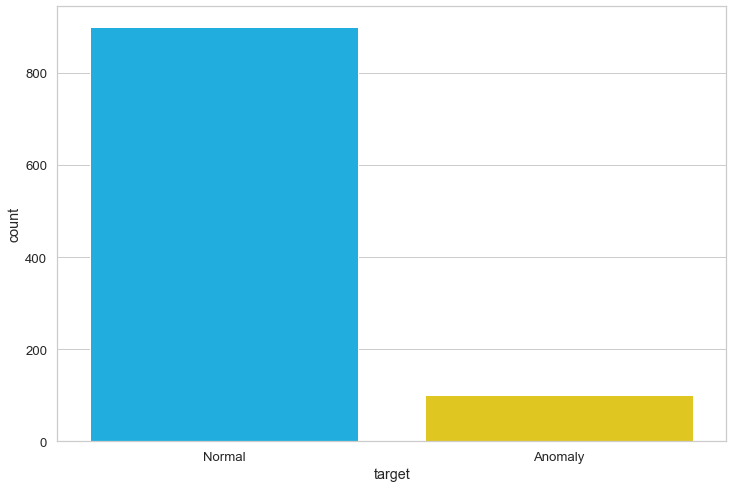

In [14]:
ax = sns.countplot(df.target)
ax.set_xticklabels(class_names);

In [15]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
    time_series_df = pd.DataFrame(data)

    smooth_path = time_series_df.rolling(n_steps).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps).std()

    under_line = (smooth_path - path_deviation)[0]
    over_line = (smooth_path + path_deviation)[0]

    ax.plot(smooth_path, linewidth=2)
    ax.fill_between(
        path_deviation.index,
        under_line,
        over_line,
        alpha=.125
        )
    ax.set_title(class_name)

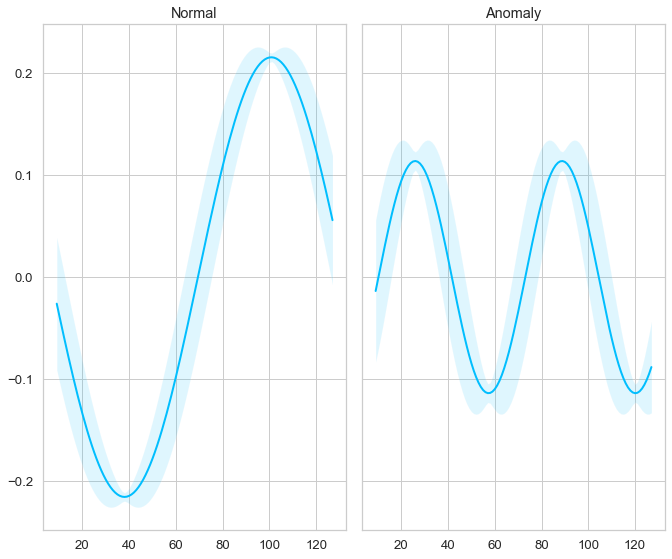

In [16]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = df[df.target == cls] \
        .drop(labels='target', axis=1) \
        .mean(axis=0) \
        .to_numpy()
    plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

In [17]:
stCLASS_NORMAL = 'b\'{0:d}\''.format(CLASS_NORMAL)

stCLASS_NORMAL = '{0:d}'.format(CLASS_NORMAL)

normal_df = df[df.target == eval(stCLASS_NORMAL)].drop(labels='target', axis=1)
# normal_df.shape

In [18]:
anomaly_df = df[df.target != eval(stCLASS_NORMAL)].drop(labels='target', axis=1)
# anomaly_df.shape

In [19]:
train_df, val_df = train_test_split(normal_df,test_size=0.15,random_state=RANDOM_SEED)
val_df, test_df = train_test_split(val_df,test_size=0.33,random_state=RANDOM_SEED)

In [20]:
def create_dataset(df):
    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

In [21]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [22]:
print('Train:         ',len(train_dataset),train_dataset[0].shape)
print('Validate:      ',len(val_dataset),val_dataset[0].shape)
print('Test Normal:   ',len(test_normal_dataset),test_normal_dataset[0].shape)
print('Test Anomaly:  ',len(test_anomaly_dataset),test_anomaly_dataset[0].shape)

Train:          765 torch.Size([128, 1])
Validate:       90 torch.Size([128, 1])
Test Normal:    45 torch.Size([128, 1])
Test Anomaly:   100 torch.Size([128, 1])


In [23]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len,       self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        self.rnn1 = nn.LSTM(input_size  = n_features,
                            hidden_size = self.hidden_dim,
                            num_layers  = 1,
                            batch_first = True)

#         self.rnn12= nn.LSTM(input_size  = self.hidden_dim,
#                             hidden_size = self.hidden_dim,
#                             num_layers  = num_layers,
#                             batch_first = True)

        self.rnn2 = nn.LSTM(input_size  = self.hidden_dim,
                            hidden_size = embedding_dim,
                            num_layers  = 1,
                            batch_first = True)

    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))

        x, (_, _) = self.rnn1(x)
#         x, (_, _) = self.rnn12(x)
        x, (hidden_n, _) = self.rnn2(x)

        return hidden_n.reshape((self.n_features, self.embedding_dim))

In [24]:
class Decoder(nn.Module):

    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len,    self.input_dim  = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features

        self.rnn1 = nn.LSTM(input_size  = input_dim,
                            hidden_size = input_dim,
                            num_layers  = 1,
                            batch_first = True)

#         self.rnn12= nn.LSTM(input_size  = input_dim,
#                             hidden_size = input_dim,
#                             num_layers  = num_layers,
#                             batch_first = True)

        self.rnn2 = nn.LSTM(input_size  = input_dim,
                            hidden_size = self.hidden_dim,
                            num_layers  = 1,
                            batch_first = True)

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))

        x, (hidden_n, cell_n) = self.rnn1(x)
#         x, (hidden_n, cell_n) = self.rnn12(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))

        return self.output_layer(x)

In [25]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [26]:
model = RecurrentAutoencoder(seq_len, n_features, 64)
model = model.to(device)

In [27]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[], val=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0

    for epoch in range(1, n_epochs + 1):
        model = model.train()

        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()

            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:

                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [28]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=50
)

Epoch 1: train loss 81.49130977057165 val loss 81.34854617648655
Epoch 2: train loss 81.4253133935866 val loss 81.34553434583876
Epoch 3: train loss 81.42323770959393 val loss 81.34817148844401
Epoch 4: train loss 81.41442272709865 val loss 81.33579889933269
Epoch 5: train loss 81.32037418340546 val loss 81.17636879814995
Epoch 6: train loss 81.31621238359439 val loss 80.46263987223307
Epoch 7: train loss 79.8069427290773 val loss 77.52290691799588
Epoch 8: train loss 80.10729306289574 val loss 81.37392027113172
Epoch 9: train loss 79.12490161072974 val loss 64.9043308681912
Epoch 10: train loss 78.03577276491652 val loss 75.8995009528266
Epoch 11: train loss 76.24046209497389 val loss 79.28534732394748
Epoch 12: train loss 79.10568959853228 val loss 81.3463373819987
Epoch 13: train loss 81.20440776550691 val loss 81.16234690348307
Epoch 14: train loss 80.73068977306092 val loss 75.5323146396213
Epoch 15: train loss 77.38311559141071 val loss 81.07898712158203
Epoch 16: train loss 75.9

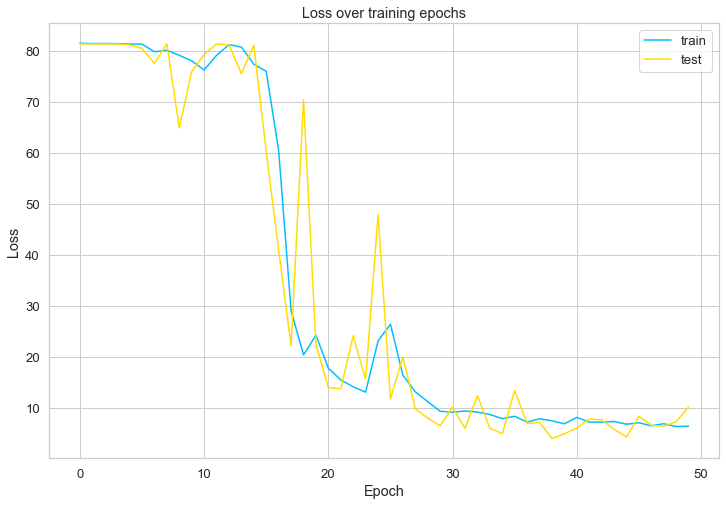

In [29]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [30]:
MODEL_PATH = 'SINE_model.pth'

torch.save(model, MODEL_PATH)


# model = torch.load(MODEL_PATH)
# model = model.to(device)

In [31]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

/Users/jk/opt/anaconda3/envs/p39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


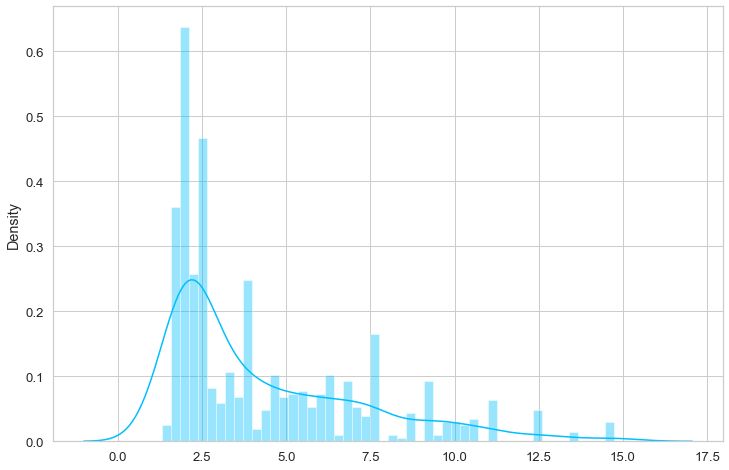

In [32]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

In [42]:
THRESHOLD = 20

/Users/jk/opt/anaconda3/envs/p39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


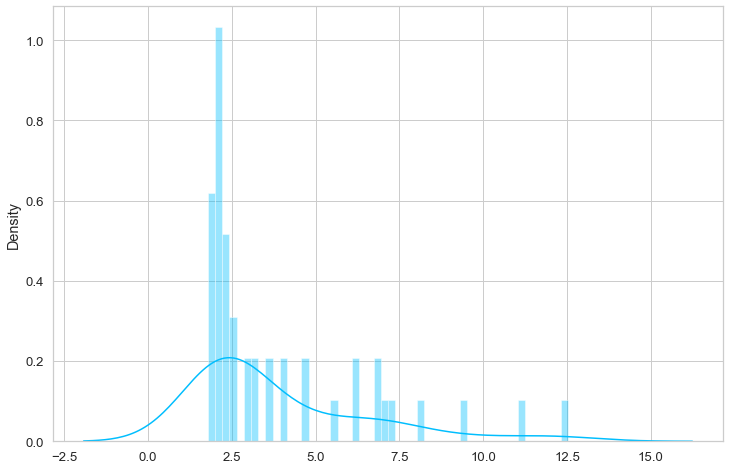

In [43]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [44]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 45/45


In [45]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

/Users/jk/opt/anaconda3/envs/p39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


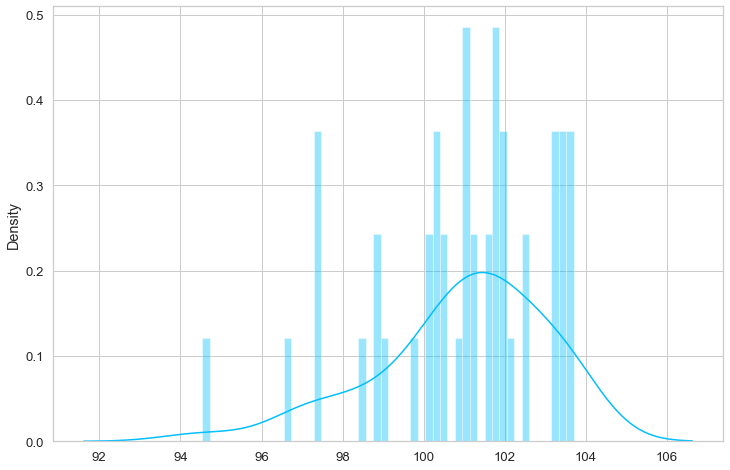

In [46]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [47]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 45/45


In [48]:
def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])

    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()

In [49]:
# fig, axs = plt.subplots(
#   nrows=2,
#   ncols=6,
#   sharey=True,
#   sharex=True,
#   figsize=(22, 8)
# )

# for i, data in enumerate(test_normal_dataset[:6]):
#     plot_prediction(data, model, title='Normal', ax=axs[0, i])

# for i, data in enumerate(test_anomaly_dataset[:6]):
#     plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

# fig.tight_layout();

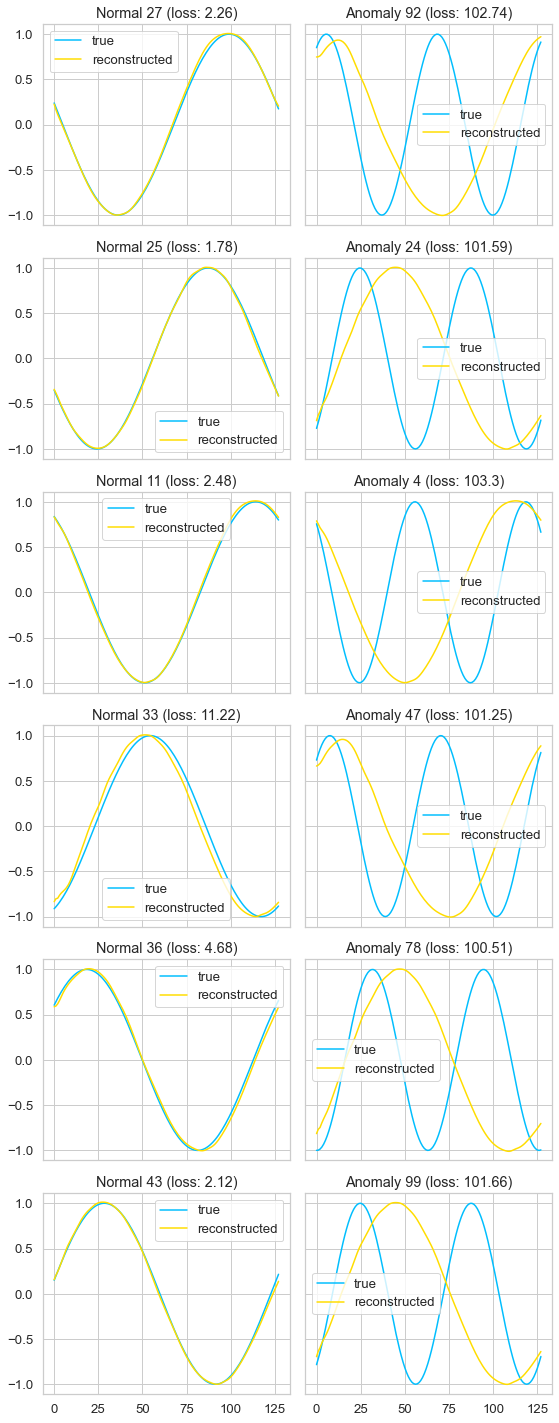

In [50]:
fig, axs = plt.subplots(
  nrows=6,
  ncols=2,
  sharey=True,
  sharex=True,
  figsize=(8,20)
)

for i in range(6):
    i0 = np.random.randint(len(test_normal_dataset))
    plot_prediction(test_normal_dataset[i0],  model, title='Normal {0:d}'.format(i0),  ax=axs[i,0])
    i0 = np.random.randint(len(test_anomaly_dataset))
    plot_prediction(test_anomaly_dataset[i0], model, title='Anomaly {0:d}'.format(i0), ax=axs[i,1])

fig.tight_layout();